In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('../data/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rank                                        2640 non-null   int64  
 1   finalWorth                                  2640 non-null   int64  
 2   category                                    2640 non-null   object 
 3   personName                                  2640 non-null   object 
 4   age                                         2575 non-null   float64
 5   country                                     2602 non-null   object 
 6   city                                        2568 non-null   object 
 7   source                                      2640 non-null   object 
 8   industries                                  2640 non-null   object 
 9   countryOfCitizenship                        2640 non-null   object 
 10  organization

In [ ]:
print(df.isnull().sum())
msno.matrix(df) # or msno.bar()

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
# 직업 카테고리
category = df['category'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(category,labels=category.index, autopct='%1.1f%%')
plt.title('Category')
plt.show

In [ ]:
# 억만장자 거주나라
countries = df['country'].value_counts().head(7)
plt.figure(figsize=(10, 6))
plt.bar(countries.index, countries.values)
plt.xlabel('Country')
plt.ylabel('Number of Billionaires')
plt.title('Countries with the Highest Number of Billionaires')
plt.show()

In [ ]:
# 지도통해서 데이터 시각화 돌리지 않아도 괜찮습니다.
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

spatial_data = df[['latitude_country','longitude_country','country']]
spatial_data=spatial_data.dropna()

data = spatial_data.copy()
data = data.rename(columns={'latitude_country': 'Latitude',
                        'longitude_country': 'Longitude',
                        'country':'Country'})

# Group by country and count the number of billionaires
billionaires_count = data.groupby('Country').size().reset_index(name='Billionaires')

# Load world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge world map with billionaires count data
world = world.merge(billionaires_count, how='left', left_on='name', right_on='Country')

# Fill missing values with 0 (for countries without billionaires)
world['Billionaires'] = world['Billionaires'].fillna(0)

# Create choropleth map
m = folium.Map(location=[30, 0], zoom_start=2)

folium.Choropleth(
    geo_data=world,
    name='choropleth',
    data=billionaires_count,
    columns=['Country', 'Billionaires'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Billionaires',
).add_to(m)

# Add markers for individual billionaires (optional)
marker_cluster = MarkerCluster().add_to(m)
for index, row in data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f'Country: {row["Country"]}',
        icon=None  # You can customize the marker icon here
    ).add_to(marker_cluster)

# Display the map
m.save('billionaires_map.html')
m

In [ ]:
print(df['category'].equals(df['industries'])) # 같은 데이터를 가지고 있는지 확인
print(df['country'].equals(df['countryOfCitizenship']))

In [ ]:
choice = df['country'] == df['countryOfCitizenship']
choice.value_counts(False)

대체

firstname -> 결측값이 적어 직접 인터넷 검색 인도네시아 사업가, 리한나(Fenty), 제이지(Carter)제이지는 가명이라  라스트 네임(shawn)도 바꿀까 생각중  3개뿐이라 엑셀에서 자체수정

country -> 이름이 있는 인물들은 직접 검색

city-> 각 coutry 및 state를 확인 없다면 coutry에서 가장많은 city로 대체

age,month -> 추론 가능 데이터 없음 age가 비어있는 인원은 다른 값들도 많이 비워져 있음 및 정규분포 데이터이므로 mean값으로 대체

cpi -> hongkong: 105.5 , monaco: , 타이완: 106.9

삭제

firstname, lastname, city, source -> city는 나라가 있기 때문에 삭제, source는 보류 및 삭제, 이름은 다른 데이터 전처리 예외처리 사용 및 삭제

country 결측값들은 county 같은 인원들을 뽑아 mean 값으로 처리 하려했으나 country 없는 데이터는 다른 데이터 결측값도 많아 삭제

oganization -> city & country & industries로 추론해보려 했으나 3가지 컬럼이 같아도 다른 회사인 경우 많아 삭제

industries -> category와 동일한 데이터 삭제

title -> 중요한 정보이나 추론 가능성 모르겠음

rank -> index와 같은 역할 삭제

birthDate,birthYear,brithDay -> age가 있으므로 삭제 Month는 사용

state -> 미국이 아닌경우 추론 불가 좋은 데이터이나 미국에만 적용되므로 삭제

residenceStateRegion -> country 또는 state랑 같은 부분이라 삭제

personName -> fistname과 last네임 이랑 겹치므로 삭제

date 수집날짜는 같은 날짜 시간만 다르기 때문에 삭제

보류

latitude_country, longitude_country 위도 경도 삭제? -> 추후 결정

country -> countryOfCitizenship 와 비슷하나 다른 값들도 많아 보류 확인차 검색해 보았는데 국가가 countryOfCitizenship쪽으로 설명이 많음

In [3]:
def get_X(df:pd.DataFrame):
  '''Make feature vectors from a DataFrame.

  Args:
      df: DataFrame
      features: selected columns
  '''
  df['gdp_country'] = df['gdp_country'].str.replace('$','')
  df['gdp_country'] = df['gdp_country'].str.replace(',','')
  df['gdp_country'] = df['gdp_country'].astype('float64')

  # 나이 빈 데이터 평균값으로 대체
  df['age'].fillna(df['age'].mean(), inplace=True)
  
  # country 빈 데이터 시민권으로 대체
  df['country'].fillna(df['countryOfCitizenship'],inplace=True)
  
  # 시민권별로 그룹화하고 윗 내용으로 결측값 처리
  df = df.groupby('countryOfCitizenship').fillna(method='ffill') 
  df['city'].fillna('New York',inplace=True)
  df.fillna(df.mean(numeric_only=True),inplace=True)
  
  '''
  # 원핫인 코딩을 위한 처리
  df['gender'] = df['gender'].map({'F': 0, 'M': 1})
  df['status'] = df['status'].map({'U': 0, 'D': 1,'N': 2, 'Split Family Fortune': 3,'E': 4, 'R': 5})
  df['category'] = df['category'].map({'Fashion & Retail': 0, 'Automotive': 1,'Technology': 2, 'Finance & Investments': 3,'Media & Entertainment': 4, 'Telecom': 5,'Diversified': 6, 'Food & Beverage': 7,'Logistics': 8, 'Gambling & Casinos': 9, 'Manufacturing': 10,'Real Estate': 11, 'Metals & Mining': 12, 'Energy': 13,'Healthcare': 14, 'Service': 15,'Construction & Engineering': 16, 'Sports': 17})
  '''
      
  # 나이 10대 별로 분배
  def category_age(x):
        if x < 20:
            return 0
        elif x < 30:
            return 1
        elif x < 40:
            return 2
        elif x < 50:
            return 3
        elif x < 60:
            return 4
        elif x < 70:
            return 5
        elif x < 80:
            return 6
        elif x < 90:
            return 7
        elif x < 100:
            return 8
        else:
            return 9

  df['age'] = df['age'].apply(category_age)
  
  def category_month(x):
      if x < 3:
          return 0
      elif x < 6:
          return 1
      elif x < 9:
          return 2
      elif x < 12:
          return 3
      else:
          return 0
      
  df['birthMonth'] = df['birthMonth'].apply(category_month)
  # 필요없는 columns delete
  # .dropna(thresh=int(len(data)*0.5),axis=1) 50% 이상 데이터가 없을 경우 삭제
  df.drop(['source','city','lastName','firstName','selfMade','title','rank','state','residenceStateRegion','date','personName','birthDay','birthDate','birthYear','organization'], axis=1, inplace=True)
  '''
  # 원-핫 인코딩
  pd.get_dummies(df['status']).to_numpy(dtype=np.float64)
  pd.get_dummies(df['gender']).to_numpy(dtype=np.float64)
  pd.get_dummies(df['category']).to_numpy(dtype=np.float64)
  pd.get_dummies(df['age']).to_numpy(dtype=np.float64)
  pd.get_dummies(df['birthMonth']).to_numpy(dtype=np.float64)
  '''
  print('Missing Value: \n',df.isnull().sum())
  msno.matrix(df)
  return pd.get_dummies(df).to_numpy(dtype=np.float64)

def get_y(df:pd.DataFrame):
  '''Make the target from a DataFrame.

  Args:
      df: DataFrame
  '''
  print(df['selfMade'].value_counts())
  return df.selfMade.to_numpy(dtype=np.float64)

결측값:  finalWorth                                    0
category                                      0
age                                           0
country                                       0
industries                                    0
status                                        0
gender                                        0
birthMonth                                    0
cpi_country                                   0
cpi_change_country                            0
gdp_country                                   0
gross_tertiary_education_enrollment           0
gross_primary_education_enrollment_country    0
life_expectancy_country                       0
tax_revenue_country_country                   0
total_tax_rate_country                        0
population_country                            0
latitude_country                              0
longitude_country                             0
dtype: int64
selfMade
True     1812
False     828
Name: count, dtype: int64


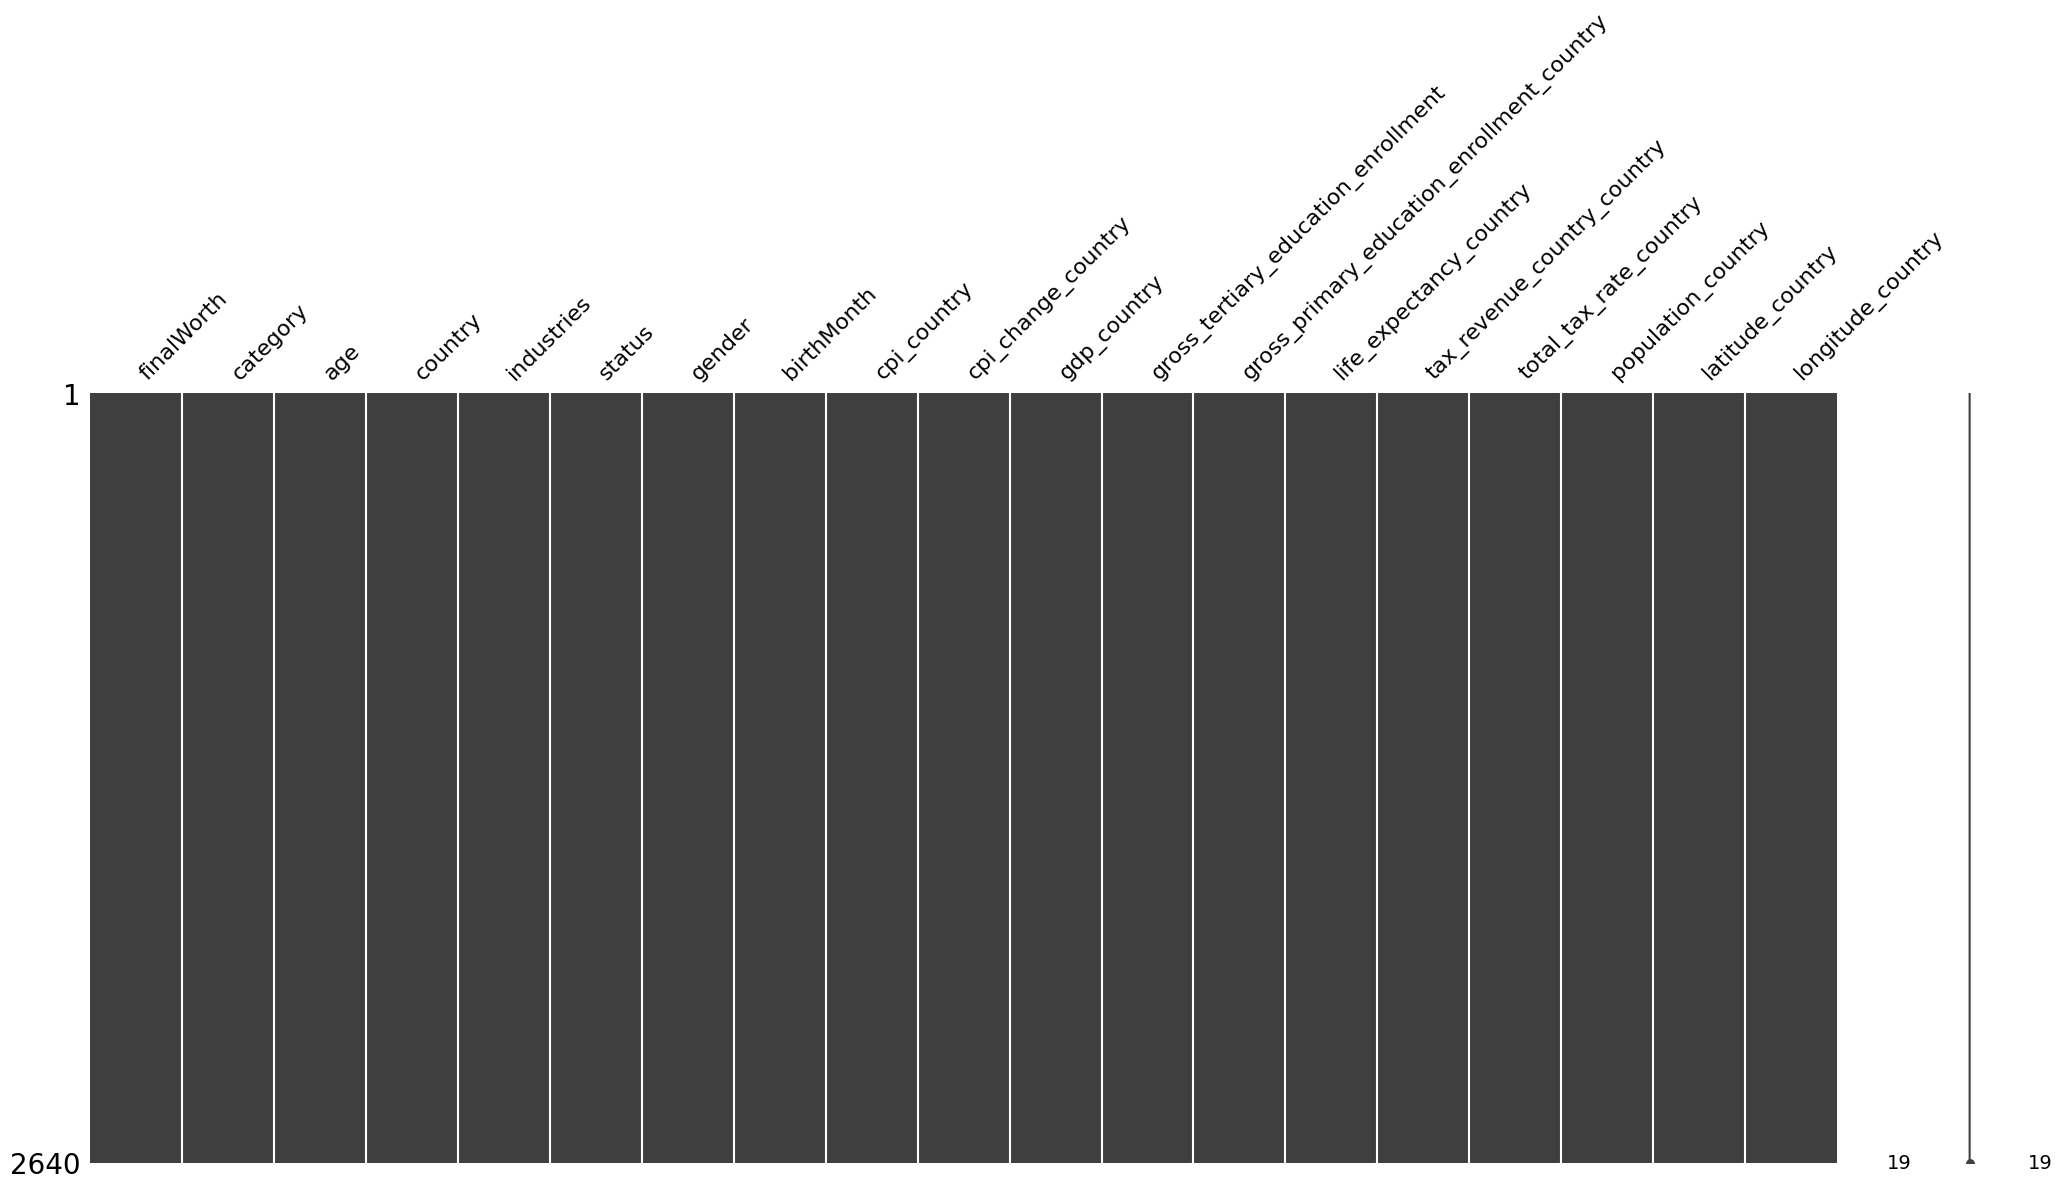

In [4]:
X_trn = get_X(df)
y_trn = get_y(df)

In [5]:
X_trn.shape, y_trn.shape

((2640, 137), (2640,))

고려 사항

샘플링 -> 데이터가 불균형하지만 양이 적음

스케일링 -> 데이터 이상치 column들이 좀 있음

In [ ]:
# 귀무가설로 데이터 설명력(R-squrd)와 P-value값을 확인 하는 코드 칼럼이 많아서 작동 x
import statsmodels.api as sm 
model=sm.Logit(y_trn.astype(float),X_trn.astype(float))
result=model.fit()
print(result.summary2())

데이터 분할

trn 데이터를 test와 train으로 나눈 후 

train을 다시 val과 train으로 나누어 파라미터 값 확인

파라미터 확인 후 정밀도 확인 할 경우 val + train 데이터 활용

**당장은 틀과 전처리에 신경써서 활용x**

In [ ]:
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(X_trn,y_trn,test_size=0.2,stratify=y_trn,random_state=10)

Randomforest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import warnings
warnings.simplefilter("ignore")

In [ ]:
pipe=Pipeline([ 
    ('scaler',StandardScaler()),
    ('clf', RandomForestClassifier(random_state=0))
])
params={
    'clf__max_depth': list(range(3,6)),
    'clf__n_estimators': list(range(10,110,10))
}
grid=GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X_trn,y_trn)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
# randomforest가 생각하는 중요도 뽑는 코드 칼럼이 많아서 실행 x
import numpy as np 
import matplotlib.pyplot as plt 
tree=grid.best_estimator_['clf']
def plot_tree(model):
    n_features=X_trn.shape[1]
    plt.barh(range(n_features),model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),X_trn)
    plt.ylim(-1,n_features)
plot_tree(tree)   

In [ ]:
scoring = ['accuracy', 'precision', 'recall', 'f1']

clf = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=2023)
scores = cross_validate(clf, X_trn, y_trn, scoring=scoring, cv=5)

scores_df = pd.DataFrame(scores)
pd.concat([scores_df, scores_df.apply(['mean', 'std'])])

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
pipe=Pipeline([ 
    ('scaler',StandardScaler()), #스케일링시 74%, 없을때 65%
    ('clf', KNeighborsClassifier())
])
params={
    'clf__n_neighbors': list(range(1,11))
}
grid=GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X_trn,y_trn)
print(grid.best_params_)
print(grid.best_score_)

SVC

In [ ]:
from sklearn.svm import SVC
pipe=Pipeline([ 
    ('scaler',StandardScaler()),#스케일링시 75%, 없을때 68%
    ('clf', SVC(random_state=0))
])
params={
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'clf__gamma': [0.0001, 0.001, 0.01, 0.1]
}
grid=GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X_trn,y_trn)
print(grid.best_params_)
print(grid.best_score_)